# Traffic Congestion Prediction - Analysis & Prediction model

Date: 15th Dec 2019

Author: KUSHALI ALIAS ALKESH ESSO PRABHU DESSAI


## Import libraries and define functions

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.io import arff
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings

In [2]:
def plot_outlier(df, cols):
    l = df[cols].columns.values
    number_of_columns=12
    number_of_rows = len(l)-1/number_of_columns
    plt.figure(figsize=(number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.set_style('whitegrid')
        sns.boxplot(df[l[i]],color='orange',orient='v')
        plt.tight_layout()

In [3]:
def print_unique_value(df):
    for col in df:
        print (f"{col}: has {df[col].nunique()} total unique value")
        print(f"Unique Values: {df[col].unique()}")
        print("\n")

## File processing and data import

Scipy arff loader was not able to load the file as is. Hence we did some pre processing on te file so that it is converted to a format which can be loaded using arff loader. Following changes were done:
1. Replaced STRING by INTEGER as we saw that the two features which were marked as STRING had integer values in them
2. One feature had small case f, we converted that to F
3. Value of NO for Fire_vehicles feature in file row number 34 was swapped. We moved it to correct position. We initally thought of deleting this record but later realized that this is one of the 5 records for 12:30 time and hence we cannot delete it.
4. We changed empty values with ? so that they correctly get represented as nan values.

In [4]:
fin = open("data.arff", "rt")
data = fin.read()
data = data.replace('STRING', 'INTEGER')
data = data.replace(', f,',', F,')
data = data.replace('F, 0.0, NO, 0.0,','F, 0.0, 0.0, NO,')
data = data.replace(', ,',', ?,')
fin.close()
fin = open("data_temp.arff", "wt")
fin.writelines(data)
fin.close()

data = arff.loadarff('data_temp.arff')
df = pd.DataFrame(data[0])

## High level look at the data

In [5]:
df.head(15)

,Hour,Immobilized_bus,Broken_Truck,Vehicle_excess,Accident_victim,Running_over,Fire_vehicles,Occurrence_involving_freight,Incident_involving_dangerous_freight,Lack_of_electricity,Fire,Point_of_flooding,Manifestations,Defect_in_the_network_of_trolleybuses,Tree_on_the_road,Semaphore_off,Intermittent_Semaphore,Slowness_in_traffic_percent
0,b'7:00',0.0,0.0,b'T',0.0,0.0,b'NO',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1
1,b'7:30',0.0,0.0,b'F',0.0,0.0,b'NO',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.6
2,b'8:00',0.0,0.0,b'F',0.0,0.0,b'NO',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.7
3,b'8:30',0.0,0.0,b'F',0.0,0.0,b'NO',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2
4,b'9:00',0.0,0.0,b'F',0.0,0.0,b'NO',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.1
5,b'9:30',0.0,0.0,b'F',0.0,0.0,b'NO',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.9
6,b'10:00',0.0,0.0,b'F',0.0,0.0,b'NO',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.3
7,b'10:30',0.0,0.0,b'F',0.0,0.0,b'NO',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.2
8,b'11:00',0.0,0.0,b'F',0.0,0.0,b'NO',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.6
9,b'11:30',0.0,0.0,b'F',0.0,0.0,b'NO',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4


We see that there are 17 features and 1 target. Out of 17 features, there are 2 categorical-boolean features, 1 time feature and rest are categrical - ordinal features.

In [6]:
df.shape

(140, 18)

There are some byte objects which we will need to convert to numeric form.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 18 columns):
Hour                                     140 non-null object
Immobilized_bus                          140 non-null float64
Broken_Truck                             140 non-null float64
Vehicle_excess                           140 non-null object
Accident_victim                          138 non-null float64
Running_over                             140 non-null float64
Fire_vehicles                            140 non-null object
Occurrence_involving_freight             140 non-null float64
Incident_involving_dangerous_freight     138 non-null float64
Lack_of_electricity                      140 non-null float64
Fire                                     140 non-null float64
Point_of_flooding                        140 non-null float64
Manifestations                           140 non-null float64
Defect_in_the_network_of_trolleybuses    138 non-null float64
Tree_on_the_road              

Following high level stats about each features gives us an idea that there are outliers for some of the features (looking at min and max). Some features have 0 value for 75% records whiile some have 0 value for 50% records. That means these features will influence only small percentage of records.

In [8]:
df.describe()

,Immobilized_bus,Broken_Truck,Accident_victim,Running_over,Occurrence_involving_freight,Incident_involving_dangerous_freight,Lack_of_electricity,Fire,Point_of_flooding,Manifestations,Defect_in_the_network_of_trolleybuses,Tree_on_the_road,Semaphore_off,Intermittent_Semaphore,Slowness_in_traffic_percent
count,140.000000,140.000000,138.000000,140.000000,140.000000,138.000000,140.000000,140.000000,140.000000,140.000000,138.000000,140.000000,139.000000,140.000000,140.000000
mean,0.335714,8.007143,0.449275,0.100000,0.007143,0.007246,0.114286,0.007143,14.400000,0.035714,0.101449,0.042857,0.129496,0.014286,9.980714
std,0.652728,84.448912,0.725676,0.345578,0.084515,0.085126,0.495820,0.084515,169.022573,0.221529,0.822049,0.203262,0.463674,0.119092,4.323583
min,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-8.000000,0.000000,0.000000,0.000000,3.400000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.300000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.950000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.500000
max,4.000000,1000.000000,3.000000,2.000000,1.000000,1.000000,4.000000,1.000000,2000.000000,1.000000,3.000000,1.000000,4.000000,1.000000,23.400000


## Data pre processing

Following data pre-processing is done: 
Out of these 7th point (feature transformation/creation) is covered in next section which is "Identification of the factors causing the traffic slowness".

1. Data type conversion
2. Missing values handling
3. Duplicate records handling
4. categorical to numeric conversion
5. Convert time in form of hh:mm to minutes
6. Outlier analysis and handling
7. Feature transformation/creation

### Data type conversion
Converted byte format data to numeric

In [9]:
df['Fire_vehicles'] = df['Fire_vehicles'].str.decode('utf-8') 
df['Vehicle_excess'] = df['Vehicle_excess'].str.decode('utf-8') 

### Missing value handling
Replacing missing values with mode of respective feature. This resulted most of the missing values getting a value as 0. This seems appropriate since most of the missing data is for sparse features and using any other techniqueue (such as using target to come up with missing values) will introduce new information and trend which might not be true in this context (mainly because most of the features are sparse).

In [10]:
print(df.isnull().sum())

Hour                                     0
Immobilized_bus                          0
Broken_Truck                             0
Vehicle_excess                           0
Accident_victim                          2
Running_over                             0
Fire_vehicles                            0
Occurrence_involving_freight             0
Incident_involving_dangerous_freight     2
Lack_of_electricity                      0
Fire                                     0
Point_of_flooding                        0
Manifestations                           0
Defect_in_the_network_of_trolleybuses    2
Tree_on_the_road                         0
Semaphore_off                            1
Intermittent_Semaphore                   0
Slowness_in_traffic_percent              0
dtype: int64


#### Observation:
1. Missing value present in dataset. Total 7 missing value found.
2. Accident_victim, Incident_involving_dangerous_freight, Defect_in_the_network_of_trolleybuses and Semaphore_off features have missing values.
3. Missing value can be observered in heatmap with Yellow bar above.

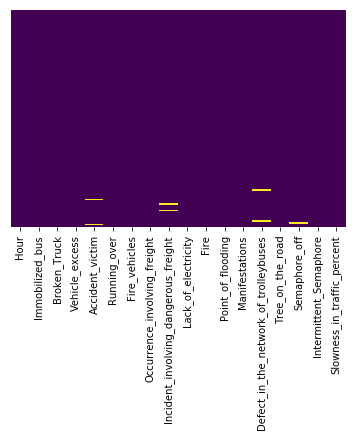

In [11]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

In [12]:
df = df.fillna(df.mode().iloc[0])

No more missing values.

In [13]:
print(df.isnull().values.sum())

0


### Duplicate record handling
Duplicate row removal. We observed that there are duplicate rows where all features as well as target are exactly same. This was resulting into false improvement in accuracy of the prediction model. We concluded that these duplicate records are truly duplicate and not a conincidence that 2 observations are having exactly same features as well as target, since its highly unlikely that all the features will exactly match and will have exactly same target.
Also we observed that for 0730 hour there are 2 duplicate records which are most likely not really duplicate as we only have 5 total observations for 0730 hours. So we decided not to remove it.

In [14]:
df.duplicated().sum()

6

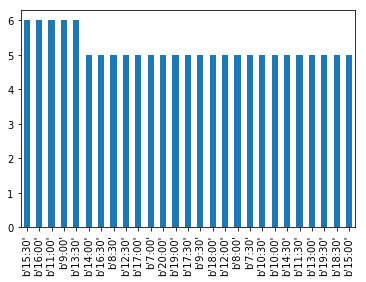

In [15]:
p=df.Hour.value_counts().plot(kind='bar')

In [16]:
type(df)

pandas.core.frame.DataFrame

In [17]:
df_730 = df[df['Hour'] ==  b'7:30']
df_rest = df[df['Hour'] !=  b'7:30']

In [18]:
warnings.filterwarnings('ignore')
duplicateRowsDF = df_rest[df_rest.duplicated()]
df_rest.drop_duplicates(inplace=True)

In [19]:
df_rest.duplicated().sum()

0

In [20]:
df_rest.append(df_730)
df = df_rest

Now we have 5 observations per day

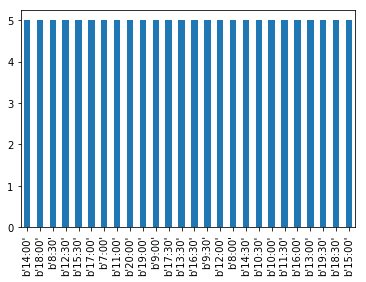

In [21]:
p=df.Hour.value_counts().plot(kind='bar')

In [22]:
df.shape

(130, 18)

In [23]:
df_backup = df

### Categorical to numeric conversion
Converted boolean categorical values to numeric

In [24]:
df['Fire_vehicles'] = df['Fire_vehicles'].map({'YES': 1, 'NO': 0})
df['Vehicle_excess'] = df['Vehicle_excess'].map({'T': 1, 'F': 0})

In [25]:
df.head()

,Hour,Immobilized_bus,Broken_Truck,Vehicle_excess,Accident_victim,Running_over,Fire_vehicles,Occurrence_involving_freight,Incident_involving_dangerous_freight,Lack_of_electricity,Fire,Point_of_flooding,Manifestations,Defect_in_the_network_of_trolleybuses,Tree_on_the_road,Semaphore_off,Intermittent_Semaphore,Slowness_in_traffic_percent
0,b'7:00',0.0,0.0,1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1
2,b'8:00',0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.7
3,b'8:30',0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2
4,b'9:00',0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.1
5,b'9:30',0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.9


### Convert Hour to numeric (minutes)
Converted hour column to time in terms of mins (e.g 7:30 is converted to 450 which is 7*60+30). 

In [26]:
time=df['Hour'].str.decode("utf-8").astype(str).str.split(':', expand=True).astype(int)
df['time'] = time[0] * 60 + time[1]

In [27]:
df_backup = df

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 139
Data columns (total 19 columns):
Hour                                     130 non-null object
Immobilized_bus                          130 non-null float64
Broken_Truck                             130 non-null float64
Vehicle_excess                           130 non-null int64
Accident_victim                          130 non-null float64
Running_over                             130 non-null float64
Fire_vehicles                            130 non-null int64
Occurrence_involving_freight             130 non-null float64
Incident_involving_dangerous_freight     130 non-null float64
Lack_of_electricity                      130 non-null float64
Fire                                     130 non-null float64
Point_of_flooding                        130 non-null float64
Manifestations                           130 non-null float64
Defect_in_the_network_of_trolleybuses    130 non-null float64
Tree_on_the_road                

### Unique values, Outlier analysis and handling

We observed outliers for some of the features. They did not have any particular correlation with target (observed from univariate analysis that was done before outlier removal. Mode was selected as appropriate value for replacement based on same argument mentioned in missing value replacement.

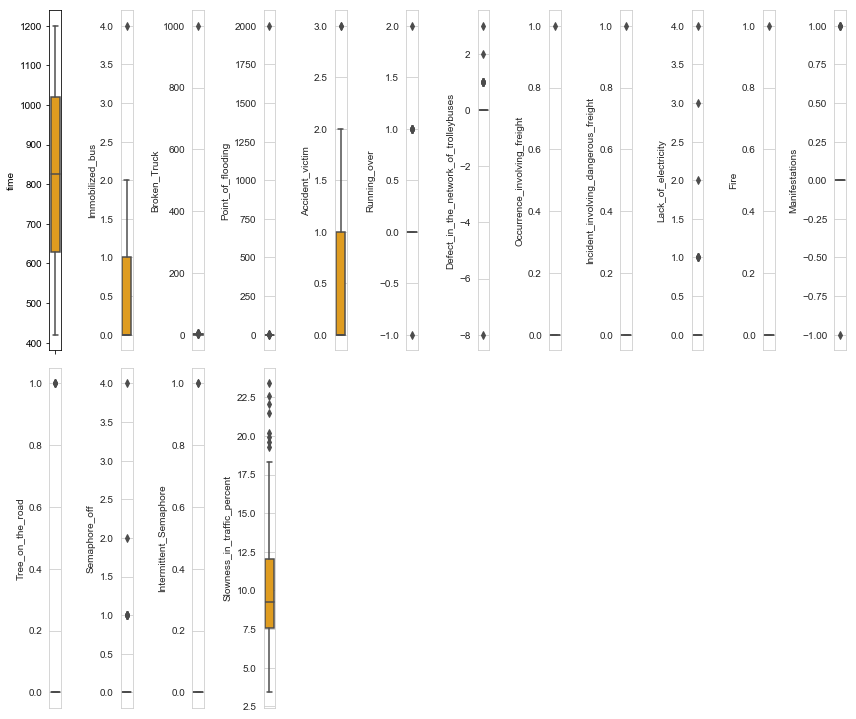

In [29]:
categorical_vars = ['Vehicle_excess','Fire_vehicles']
continuous_vars = ['time','Immobilized_bus', 'Broken_Truck' ,'Point_of_flooding','Accident_victim','Running_over','Defect_in_the_network_of_trolleybuses','Occurrence_involving_freight','Incident_involving_dangerous_freight','Lack_of_electricity','Fire','Manifestations','Tree_on_the_road','Semaphore_off','Intermittent_Semaphore','Slowness_in_traffic_percent']
plot_outlier(df,continuous_vars)

Unique values across all features and target

In [30]:
print_unique_value(df)

Hour: has 26 total unique value
Unique Values: [b'7:00' b'8:00' b'8:30' b'9:00' b'9:30' b'10:00' b'10:30' b'11:00'
 b'11:30' b'12:00' b'12:30' b'13:00' b'13:30' b'14:00' b'14:30' b'15:00'
 b'15:30' b'16:00' b'16:30' b'17:00' b'17:30' b'18:00' b'18:30' b'19:00'
 b'19:30' b'20:00']


Immobilized_bus: has 4 total unique value
Unique Values: [0. 2. 1. 4.]


Broken_Truck: has 7 total unique value
Unique Values: [   0. 1000.    2.    1.    5.    4.    3.]


Vehicle_excess: has 2 total unique value
Unique Values: [1 0]


Accident_victim: has 4 total unique value
Unique Values: [0. 1. 2. 3.]


Running_over: has 4 total unique value
Unique Values: [ 0.  1.  2. -1.]


Fire_vehicles: has 2 total unique value
Unique Values: [0 1]


Occurrence_involving_freight: has 2 total unique value
Unique Values: [0. 1.]


Incident_involving_dangerous_freight: has 2 total unique value
Unique Values: [0. 1.]


Lack_of_electricity: has 5 total unique value
Unique Values: [0. 1. 2. 4. 3.]


Fire: has 2 total uniq

Based on above analysis following outliers are handled by replacing them with mode

In [31]:
df['Running_over'].replace(-1,df['Running_over'].mode()[0],inplace=True)
df['Point_of_flooding'].replace(2000,df['Point_of_flooding'].mode()[0],inplace=True)
df['Defect_in_the_network_of_trolleybuses'].replace(-8,df['Defect_in_the_network_of_trolleybuses'].mode()[0],inplace=True)
df['Manifestations'].replace(-1,df['Manifestations'].mode()[0],inplace=True)
df['Broken_Truck'].replace(1000,df['Broken_Truck'].mode()[0],inplace=True)

## Identification of the factors causing the traffic slowness

Here we have done:
    1. Explorator data analysis: Univariate and Bivariate
    2. Derived attributes are identified and created
    3. Observations and insights are documented 
    4. Major contributors to traffic slowness are identified.

### Univariate and Bivariate analysis


Looks like we have 5 days of data starting from 0730 hours to 2000 hours. Based on this it looks like we have incorrectly removed the record for 0730 and and 1230 hours since we see only 4 observations below.
After going back and correcting it, we see 5 records for every hour.

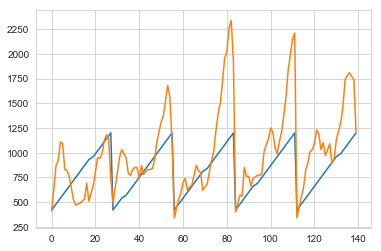

In [32]:
plt.plot(df['time'])
plt.plot(df['Slowness_in_traffic_percent']*100)

In [33]:
df.columns

Index(['Hour', 'Immobilized_bus', 'Broken_Truck', 'Vehicle_excess',
       'Accident_victim', 'Running_over', 'Fire_vehicles',
       'Occurrence_involving_freight', 'Incident_involving_dangerous_freight',
       'Lack_of_electricity', 'Fire', 'Point_of_flooding', 'Manifestations',
       'Defect_in_the_network_of_trolleybuses', 'Tree_on_the_road',
       'Semaphore_off', 'Intermittent_Semaphore',
       'Slowness_in_traffic_percent', 'time'],
      dtype='object')

In [34]:
df = df.drop(['Hour'], 1)

### Correlation between all the features and between features and target

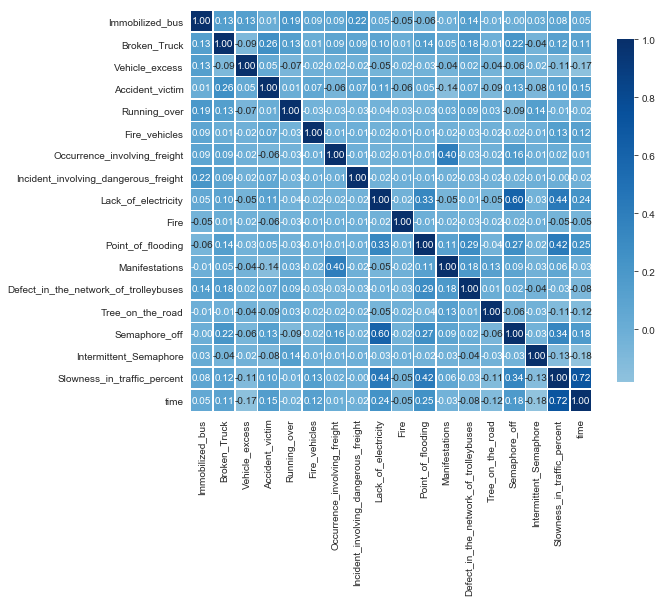

In [35]:
def correlation_heatmap(li):
    correlations = li.corr()

    fig, ax = plt.subplots(figsize=(9,9))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',cmap='Blues',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df)

#### Observations:

1. Above we see that time has highest correlation with target (72%), followed by lack of electricity (44%) and point of flooding (42%). We are going to analyze tis further below.

2. Also we see medium correlation between 2 features: Lack of electicity and semaphone off (60%). We will analyze this further later.

### time v/s target: 
we see a strong non linear positive correlation between time and slowness. Upto 600 there is linear increase and then it kind of flattens out between 600 to 900. After 900 there is again linear increase. This indicates we would need to introduce polynomial variation of hour feature to correctly model this relation. We could confirm this by running the model first with time and then time^2. The accuracy improved when we started using time^2 feature.

10.23307692307693


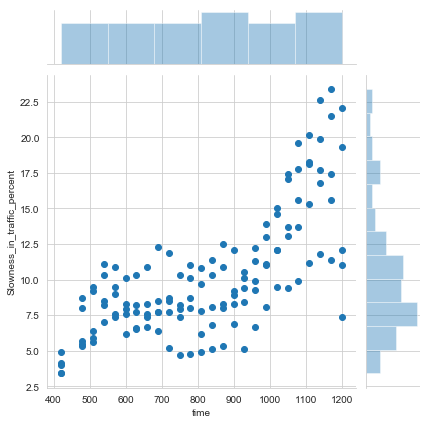

In [36]:
print(df['Slowness_in_traffic_percent'].mean())
p=sns.jointplot(x='time',y='Slowness_in_traffic_percent',data=df)

Average Traffic by time

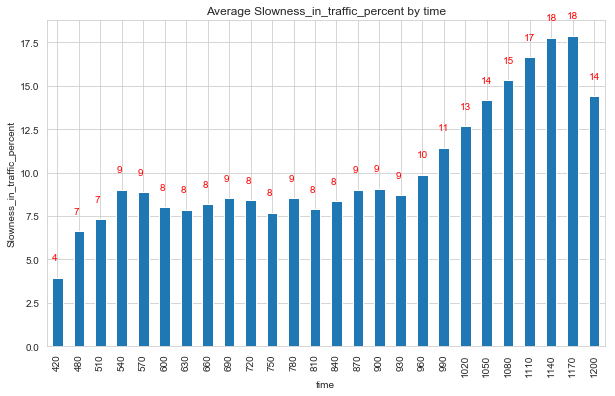

In [37]:
age_abs = df.groupby('time')[['Slowness_in_traffic_percent']].mean()
ax = age_abs.plot(kind='bar', figsize=(10,6), legend=False)
for i, v in enumerate(age_abs.values):
    ax.text(i-.25, v + 1, str(np.int(np.round(v))), color='red')
ax.set_ylabel('Slowness_in_traffic_percent')
ax.set_title('Average Slowness_in_traffic_percent by time')
plt.show()

Upto 600 there is linear increase

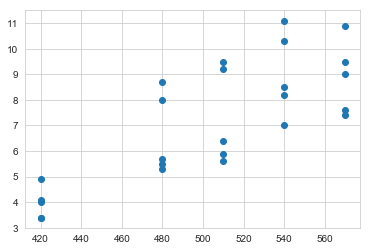

In [38]:
df1=df[df.time < 600]
p=plt.scatter(df1['time'],df1['Slowness_in_traffic_percent'])

It kind of flattens out between 600 to 900

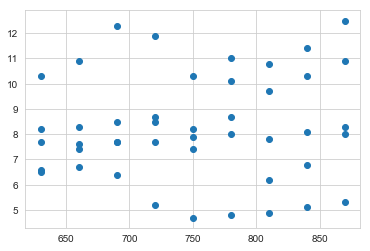

In [39]:
df1=df[df.time < 900]
df2=df1[df1.time > 600]
p=plt.scatter(df2['time'],df2['Slowness_in_traffic_percent'])

Again linear increase post 900

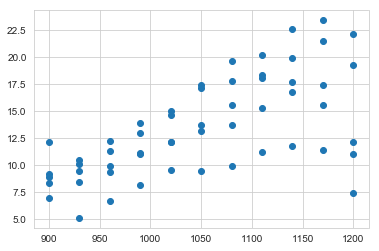

In [40]:
df1=df[df.time >= 900]
p=plt.scatter(df1['time'],df1['Slowness_in_traffic_percent'])

### Lack_of_electricity vs target: 
We see that there are a small percentage of records having value in lack of electricity but whenever there is a value there is strong positive correlation.

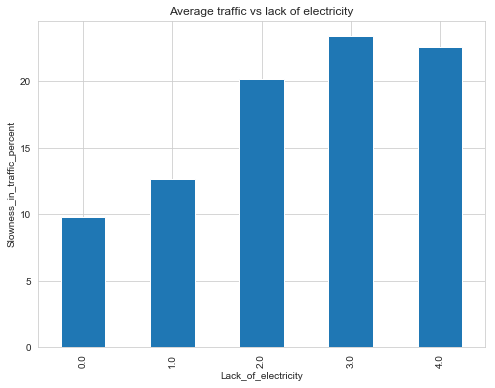

In [41]:
age_work_sum = df.groupby('Lack_of_electricity', as_index=False)[['Slowness_in_traffic_percent']].mean()
ax = age_work_sum.plot(kind='bar', x='Lack_of_electricity', figsize=(8,6), legend=False)
ax.set_ylabel('Slowness_in_traffic_percent')
ax.set_title('Average traffic vs lack of electricity')
plt.show()

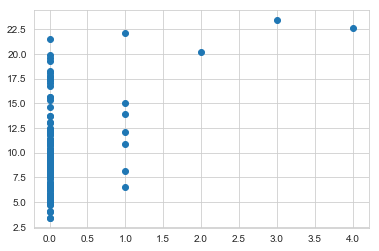

In [42]:
p=plt.scatter(df['Lack_of_electricity'],df['Slowness_in_traffic_percent'])

### Point_of_flooding vs target: 
Again there are very few records having value in point of flooding, but there is a value in this field, slowness is high.

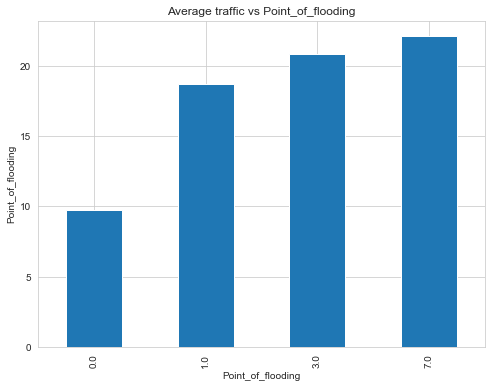

In [43]:
age_work_sum = df.groupby('Point_of_flooding', as_index=False)[['Slowness_in_traffic_percent']].mean()
ax = age_work_sum.plot(kind='bar', x='Point_of_flooding', figsize=(8,6), legend=False)
ax.set_ylabel('Point_of_flooding')
ax.set_title('Average traffic vs Point_of_flooding')
plt.show()

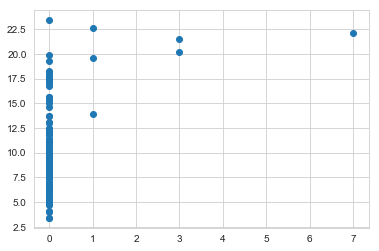

In [44]:
plt.scatter(df['Point_of_flooding'],df['Slowness_in_traffic_percent'])

### Lack of electricity vs Semaphone off:
The correlation map showed medium correlation between lack of elecrticity and semaphone off (60%). However based on further analysis we see that overall number of records having value for these features are less. Also we see that there are instances where twice lack of electricity was >0 however, semaphone off was 0.

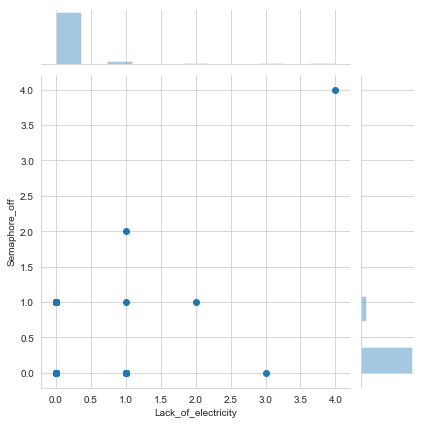

In [45]:
p=sns.jointplot(x='Lack_of_electricity',y='Semaphore_off',data=df)

### Fire_vehicles vs target: 
Only 1 record has true, and in that case slowness is high. Since there is only one record this will hardly make any difference in the model. However we need to see how we can combine this with some other sparse features so that informatio contained in this relationship is not lost.

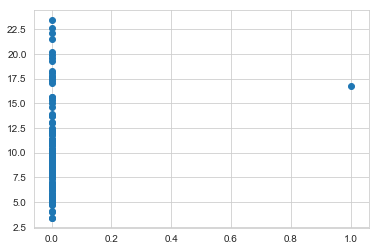

In [46]:
plt.scatter(df['Fire_vehicles'],df['Slowness_in_traffic_percent'])

### Manifestations vs target: 
Very few records have value 1 in this field. The slowness has a wide range when there value is 1. So this is a poor correlation.

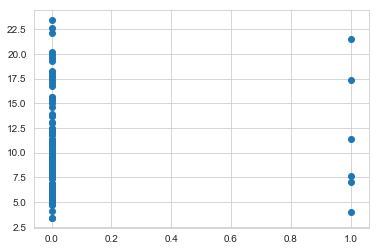

In [47]:
p=plt.scatter(df['Manifestations'],df['Slowness_in_traffic_percent'])

### Defect_in_the_network_of_trolleybuses vs target.:
We dont strong correlation here.

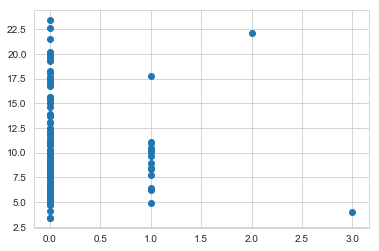

In [48]:
p=plt.scatter(df['Defect_in_the_network_of_trolleybuses'],df['Slowness_in_traffic_percent'])

### Tree_on_the_road vs target: 
Here also the correlation is not very strong.

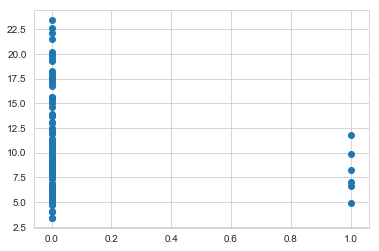

In [49]:
p=plt.scatter(df['Tree_on_the_road'],df['Slowness_in_traffic_percent'])

### Semaphore_off vs target: 
We see some correlation, but number of records are very less. Again here we can look at merging this with some other features.

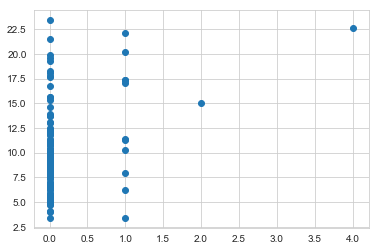

In [50]:
p=plt.scatter(df['Semaphore_off'],df['Slowness_in_traffic_percent'])

### Incident_involving_dangerous_freight vs target: 
A strong correlation when there is value of 1 but unfortunately only one record has value of 1.

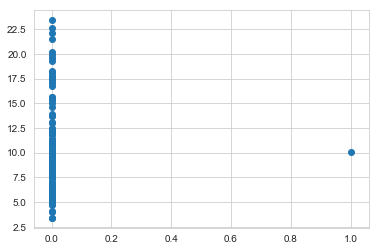

In [51]:
p=plt.scatter(df['Incident_involving_dangerous_freight'],df['Slowness_in_traffic_percent'])

### Accident_victim vs target: 
We dont see a strong correlation here.

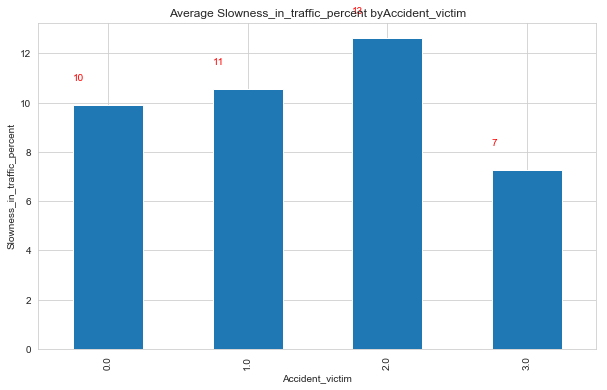

In [52]:
age_abs = df.groupby('Accident_victim')[['Slowness_in_traffic_percent']].mean()
ax = age_abs.plot(kind='bar', figsize=(10,6), legend=False)
for i, v in enumerate(age_abs.values):
    ax.text(i-.25, v + 1, str(np.int(np.round(v))), color='red')
ax.set_ylabel('Slowness_in_traffic_percent')
ax.set_title('Average Slowness_in_traffic_percent byAccident_victim')
plt.show()

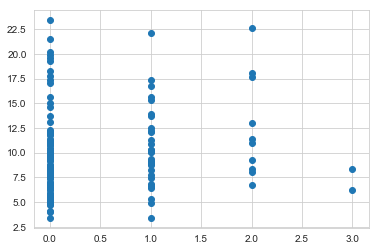

In [53]:
p=plt.scatter(df['Accident_victim'],df['Slowness_in_traffic_percent'])

### Broken_Truck vs target: 
There is a patter here. Whenever value > 0 we see that there is slowness in most of the cases and it goes up with increase in value.

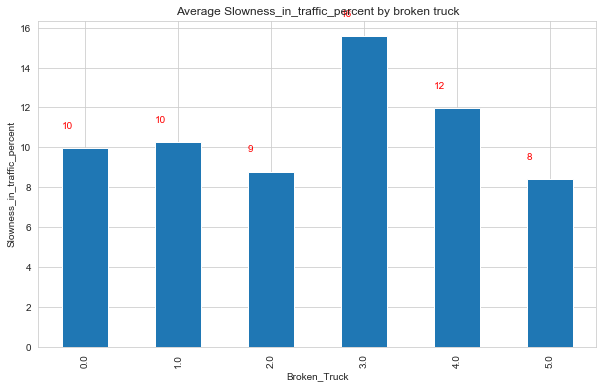

In [54]:
age_abs = df.groupby('Broken_Truck')[['Slowness_in_traffic_percent']].mean()
ax = age_abs.plot(kind='bar', figsize=(10,6), legend=False)
for i, v in enumerate(age_abs.values):
    ax.text(i-.25, v + 1, str(np.int(np.round(v))), color='red')
ax.set_ylabel('Slowness_in_traffic_percent')
ax.set_title('Average Slowness_in_traffic_percent by broken truck')
plt.show()

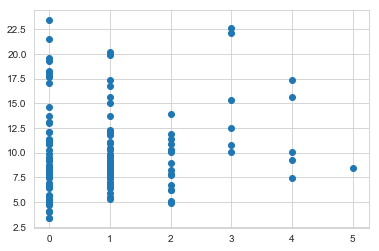

In [55]:
p=plt.scatter(df['Broken_Truck'],df['Slowness_in_traffic_percent'])

### Immobilized_bus vs target: 
There is a correlation and its somewhat similar to Broken truck.

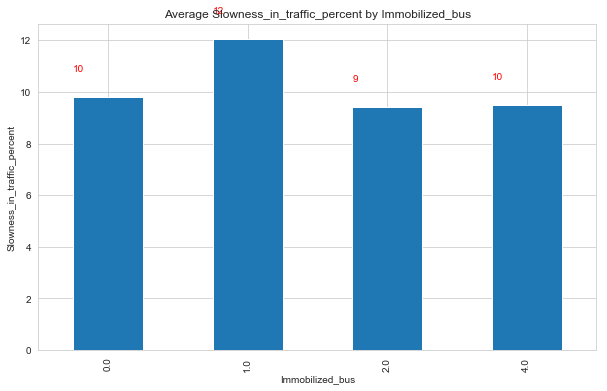

In [56]:
age_abs = df.groupby('Immobilized_bus')[['Slowness_in_traffic_percent']].mean()
ax = age_abs.plot(kind='bar', figsize=(10,6), legend=False)
for i, v in enumerate(age_abs.values):
    ax.text(i-.25, v + 1, str(np.int(np.round(v))), color='red')
ax.set_ylabel('Slowness_in_traffic_percent')
ax.set_title('Average Slowness_in_traffic_percent by Immobilized_bus')
plt.show()

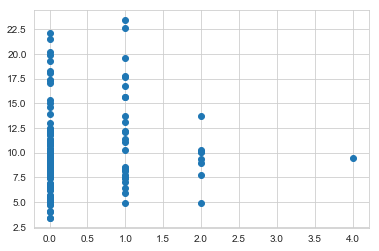

In [57]:
p=plt.scatter(df['Immobilized_bus'],df['Slowness_in_traffic_percent'])

###  Running_over vs target: 
There is a correlation but number of records are less and at value 1, there is a wide range of slowness.

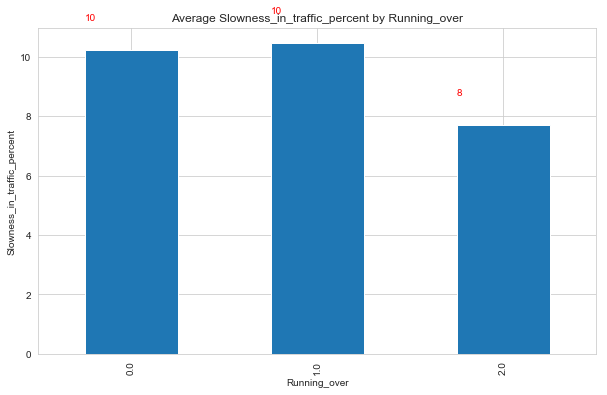

In [58]:
age_abs = df.groupby('Running_over')[['Slowness_in_traffic_percent']].mean()
ax = age_abs.plot(kind='bar', figsize=(10,6), legend=False)
for i, v in enumerate(age_abs.values):
    ax.text(i-.25, v + 1, str(np.int(np.round(v))), color='red')
ax.set_ylabel('Slowness_in_traffic_percent')
ax.set_title('Average Slowness_in_traffic_percent by Running_over')
plt.show()

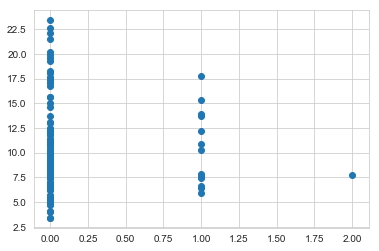

In [59]:
p=plt.scatter(df['Running_over'],df['Slowness_in_traffic_percent'])

###  Occurrence_involving_freight vs target: 
Only 1 record with value 1 with high slowness.

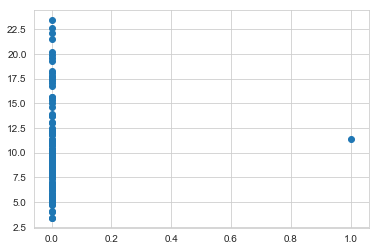

In [60]:
p=plt.scatter(df['Occurrence_involving_freight'],df['Slowness_in_traffic_percent'])

### Intermittent_Semaphore vs target: 
Only 1 record with value 1 with high slowness.

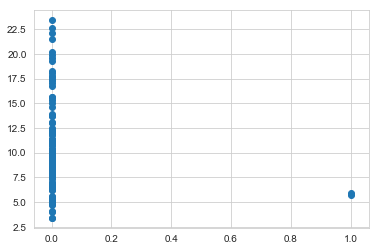

In [61]:
p=plt.scatter(df['Intermittent_Semaphore'],df['Slowness_in_traffic_percent'])

### Vehicle_excess vs target: 
Few records with value 1 and wide range of slowness.

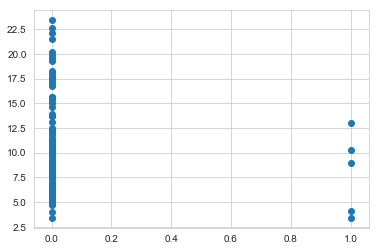

In [62]:
p=plt.scatter(df['Vehicle_excess'],df['Slowness_in_traffic_percent'])

### Fire vs Slowness_in_traffic_percent: 
Only 1 record with higher slowness.

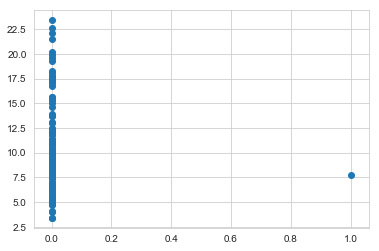

In [63]:
p=plt.scatter(df['Fire'],df['Slowness_in_traffic_percent'])

## Derived attributes - Feature engineering

Day feature is not explicitly provided in the data file. However looking at data we could infer that the records are in sequence of date. After removing duplicates there were 130 records left (there was one duplicate that we did not remove since we would have fallen short of one record in that case). For every half an hour we ended up with 5 observations for each days. Hence we marked first 26 records with day as Monday, next 26 with day as Tuesday and so on.

In [64]:
df_mon = df.iloc[0:26,:]
df_mon['day'] = 0
df_tue = df.iloc[26:52,:]
df_tue['day'] = 1
df_wed = df.iloc[52:78,:]
df_wed['day'] = 2
df_thu = df.iloc[78:104,:]
df_thu['day'] = 3
df_fri = df.iloc[104:130,:]
df_fri['day'] = 4
df = pd.concat([df_mon,df_tue,df_wed,df_thu,df_fri])

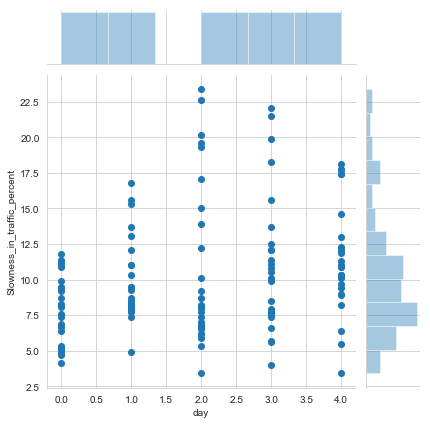

In [65]:
p=sns.jointplot(x='day',y='Slowness_in_traffic_percent',data=df)

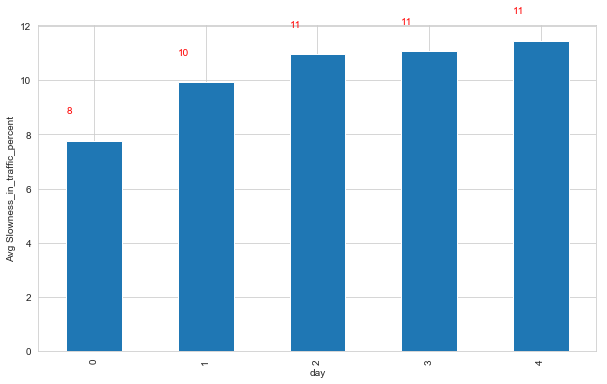

In [66]:
age_abs = df.groupby('day')[['Slowness_in_traffic_percent']].mean()
ax = age_abs.plot(kind='bar', figsize=(10,6), legend=False)
for i, v in enumerate(age_abs.values):
    ax.text(i-.25, v + 1, str(np.int(np.round(v))), color='red')
ax.set_ylabel('Avg Slowness_in_traffic_percent')
plt.show()

In [67]:
df.columns

Index(['Immobilized_bus', 'Broken_Truck', 'Vehicle_excess', 'Accident_victim',
       'Running_over', 'Fire_vehicles', 'Occurrence_involving_freight',
       'Incident_involving_dangerous_freight', 'Lack_of_electricity', 'Fire',
       'Point_of_flooding', 'Manifestations',
       'Defect_in_the_network_of_trolleybuses', 'Tree_on_the_road',
       'Semaphore_off', 'Intermittent_Semaphore',
       'Slowness_in_traffic_percent', 'time', 'day'],
      dtype='object')

We see that immobilized bus and Broken truck have similar impact on the traffic. Hence we decided to combine these 2 and create a single feature which indicates number of broken vehicles.

In [68]:
df['broken_vehicle'] = df.apply(lambda row: row['Immobilized_bus'] + row['Broken_Truck'] , axis=1)
df = df.drop(['Immobilized_bus','Broken_Truck'], 1)

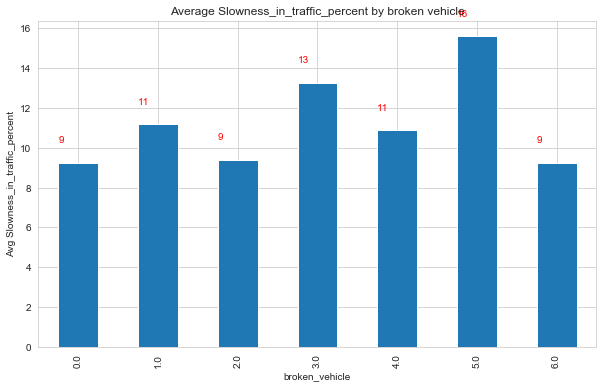

In [69]:
age_abs = df.groupby('broken_vehicle')[['Slowness_in_traffic_percent']].mean()
ax = age_abs.plot(kind='bar', figsize=(10,6), legend=False)
for i, v in enumerate(age_abs.values):
    ax.text(i-.25, v + 1, str(np.int(np.round(v))), color='red')
ax.set_ylabel('Avg Slowness_in_traffic_percent')
ax.set_title('Average Slowness_in_traffic_percent by broken vehicle')
plt.show()

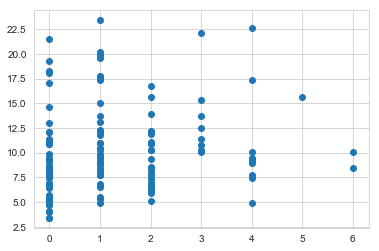

In [70]:
p=plt.scatter(df['broken_vehicle'],df['Slowness_in_traffic_percent'])

Lack of electricity and point of flooding individually where the next best predictors (after time). However they individually had lower correlation with target. Also both have very similar correlation pattern. After combining these 2 we see the that the correlation score has increased and this also resulted in improvement in accuracy of the linear regression model.

In [71]:
df['electricity_flooding'] = df.apply(lambda row: row['Lack_of_electricity'] + row['Point_of_flooding'] , axis=1)
df = df.drop(['Lack_of_electricity','Point_of_flooding'], 1)

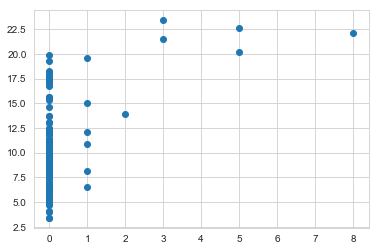

In [72]:
p=plt.scatter(df['electricity_flooding'],df['Slowness_in_traffic_percent'])

We see that Fire_Manifestations and Fire_vehicles have similar impact on the traffic. Also number of instances where these features have non zero value is very less. Hence we decided to combine these 2 and create a single feature.

In [73]:
df['Fire_Manifestations'] = df.apply(lambda row: row['Fire_vehicles'] + row['Manifestations']  , axis=1)
df = df.drop(['Fire_vehicles','Manifestations'], 1)

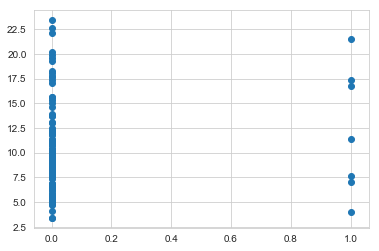

In [74]:
p=plt.scatter(df['Fire_Manifestations'],df['Slowness_in_traffic_percent'])

We see that Defect_in_the_network_of_trolleybuses and Tree_on_the_road have similar impact on the traffic. Also number of instances where these features have non zero value is very less. Hence we decided to combine these 2 and create a single feature.

In [75]:
df['Trolleybuses_tree'] = df.apply(lambda row: row['Defect_in_the_network_of_trolleybuses'] + row['Tree_on_the_road']  , axis=1)
df = df.drop(['Defect_in_the_network_of_trolleybuses','Tree_on_the_road'], 1)

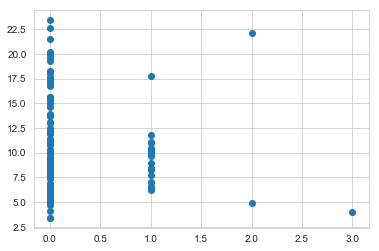

In [76]:
p=plt.scatter(df['Trolleybuses_tree'],df['Slowness_in_traffic_percent'])

We created a new feature called 'incident' to slice data based on incident=0 vs incident >0. We wanted to try out different models separately when there are incidents v/s when there are no incident and check how it influences prediction. We thought on these lines as we saw that time feature was dominating the predictions. However we could not proceed further on this because of lack of time. Hence the feature is dropped for now

In [77]:
df['incident'] = df.apply(lambda row: row['Vehicle_excess'] + row['Accident_victim'] + row['Running_over'] + row['Occurrence_involving_freight'] + row['Incident_involving_dangerous_freight'] + row['Fire'] + row['Semaphore_off'] + row['Intermittent_Semaphore'] + row['broken_vehicle'] + row['electricity_flooding'] + row['Fire_Manifestations'] + row['Trolleybuses_tree'] , axis=1)
df = df.drop(['incident'], 1)

In [78]:
df.columns

Index(['Vehicle_excess', 'Accident_victim', 'Running_over',
       'Occurrence_involving_freight', 'Incident_involving_dangerous_freight',
       'Fire', 'Semaphore_off', 'Intermittent_Semaphore',
       'Slowness_in_traffic_percent', 'time', 'day', 'broken_vehicle',
       'electricity_flooding', 'Fire_Manifestations', 'Trolleybuses_tree'],
      dtype='object')

In [79]:
df_backup = df

### Non linear transformation

Tried various non linear transformations with time (time^2, log(time), time*sqrt(time). Also normalized this data and tried checking if it improves model accuracy. Reasons for doing non linear transformation is explained in detail in univariate analysis.

In [80]:
df['time_square'] = df.apply(lambda row: row['time'] * row['time'], axis=1)
df['time_log'] = df.apply(lambda row: row['time'] * math.log(row['time'],10), axis=1)
df['time_Square_sqroot'] = df.apply(lambda row: row['time'] * math.sqrt(row['time']), axis=1)

time_sq_mean=df['time_square'].mean()
time_sq_std=df['time_square'].std()
df['time_square'] = df.apply(lambda row: (row['time_square'] - time_sq_mean)/time_sq_std , axis=1)

time_root_mean=df['time_Square_sqroot'].mean()
time_root_std=df['time_Square_sqroot'].std()
df['time_Square_sqroot'] = df.apply(lambda row: (row['time_Square_sqroot'] - time_root_mean)/time_root_std , axis=1)


Instead of doing above transformations, we found a better way of doing polynomical transformation of time which proved be equally effective. Hence dropped these polynomial features here.

In [81]:
df = df.drop(['time_square','time_log','time_Square_sqroot'], 1)

Tried converting time using circular transformation. However this did not improve results. 
Reason circular transformation did not help is because of the type of correlation between hour and target. Explained in more detail in univariate analysis

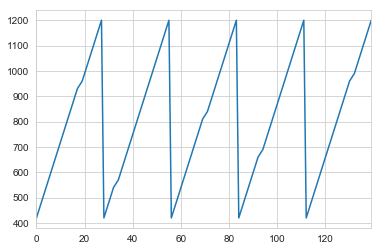

In [82]:
df.time.plot();

In [83]:
mins_in_day = 24*60
df['sin_time'] = np.sin(2*np.pi*df.time/mins_in_day)
df['cos_time'] = np.cos(2*np.pi*df.time/mins_in_day)

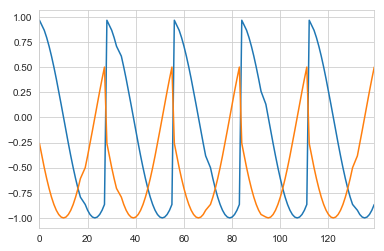

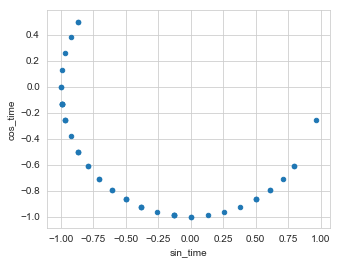

In [84]:
df.sin_time.plot()
df.cos_time.plot()
df.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');

In [85]:
#df = df.drop(['sin_time','cos_time'], 1)

### Correlation map post feature generation/tranformation
We see that new features created have following corrlelation with target:

    sin time: -61%
    
    cos time:  66%

    electricity_flooding: 52% (improved compared to individual correlations)

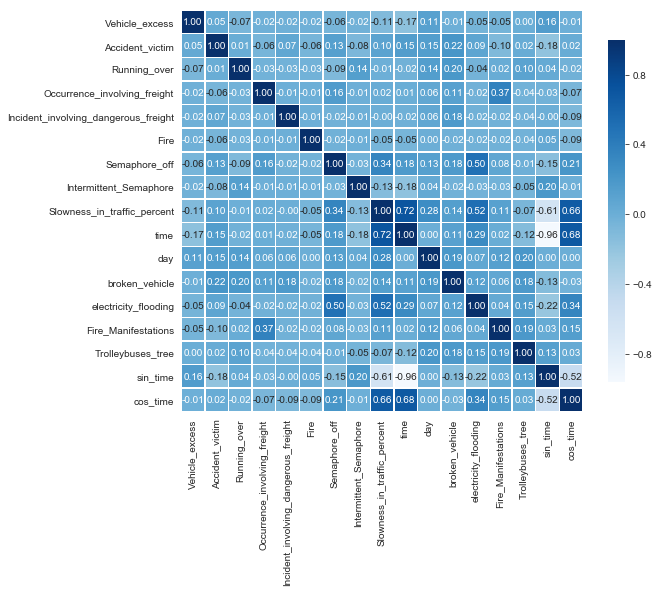

In [86]:
def correlation_heatmap(li):
    correlations = li.corr()

    fig, ax = plt.subplots(figsize=(9,9))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',cmap='Blues',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df)

Separated out features and Target into X and y

In [87]:
# Features
X = df.drop(['Slowness_in_traffic_percent'],axis=1)
y = df['Slowness_in_traffic_percent']

### Further polynomial tranformations and feature scaling

Polynomial transformation done with degree 2. This results in creation of 3 time features.

In [88]:
time_X = X[['time']]
poly = PolynomialFeatures(2)
X.drop(['time'], 1,inplace=True)
time_X_poly=poly.fit_transform(time_X,y)

In [89]:
#X = pd.concat([X, pd.DataFrame(time_X_poly,columns=['time_1','time_2','time_3'])], axis=1)
time_X_poly = pd.DataFrame(time_X_poly,columns=['time_1','time_2','time_3'])

We did StandardScaler tranformation on the 3 time features. We excluded other features from this transformation since other features are ordinal and sparse, and this transformation would have resulted in loss of info (we saw the results in model evaluation also)

In [90]:
scaler = StandardScaler()
time_X = time_X_poly[['time_1','time_2','time_3']]
scaler.fit(time_X,y)
#cols=X.columns
time_X_scaled = scaler.transform(time_X)
time_X_scaled = pd.DataFrame(time_X_scaled,columns=['time_1','time_2','time_3'])

None time features are transformed using MaxAbsScaler transformation. This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity.

In [91]:
non_time_X = X
cols=non_time_X.columns
transformer = MaxAbsScaler().fit(non_time_X)
non_time_X_scaled = transformer.transform(non_time_X)
non_time_X_scaled = pd.DataFrame(non_time_X_scaled,columns=cols)

Combined transformed time and non time features. Kept only time_3 feature (order of 2nd degree) out of 3 time features, to avoid overdominance of time features in model. We found this was best experimentally. If we include all 3 time features, RFE was eliminating all non time features and resulting accuracy was lower. Mix of time_3 and non time features gave a better accuracy.

In [92]:
X = pd.concat([time_X_scaled[['time_2','time_3']], non_time_X_scaled], axis=1)

## Target transformation

Target has some outliers as seen below:


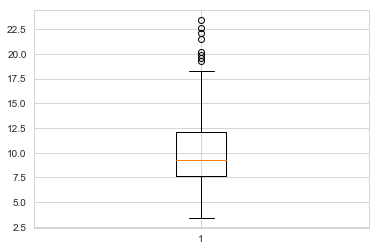

In [93]:
p=plt.boxplot(df['Slowness_in_traffic_percent'])

Having some of these high values was impacting the model learning, hence we have done log transformation to linearize the target allowing better predictios.

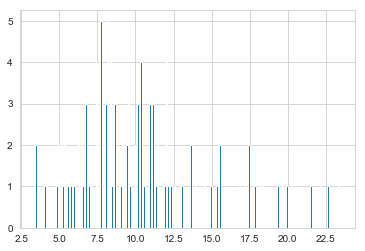

In [94]:
p= plt.hist(df['Slowness_in_traffic_percent'],bins=200)

In [95]:
y_trans = np.log1p(y)

Outliers are reduced

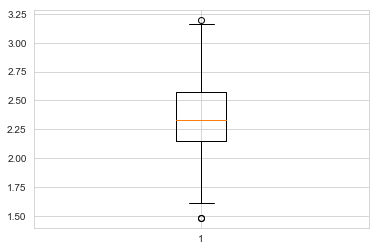

In [96]:
p=plt.boxplot(y_trans)

Target distribution is more uniform

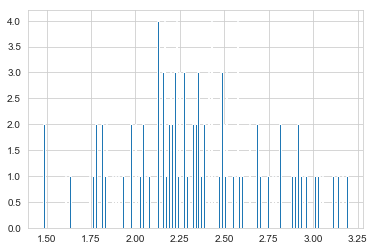

In [97]:
p= plt.hist(y_trans,bins=200)

In [98]:
y=y_trans

## Model#1: Linear Regression with RFE and cross validation strategy

Since slowness percentage is numeric, we have first modelled this problem as a regression type of problem and built a Linear Regression predictor.
We observed that since data is less, model accuracy was fluctuating based on set of records we were using for training vs testing. To overcome this problem we have used k-fold validation using 6 folds.


We are going to use k-fold validation. Before doing k-fold, we have separated out a training data set (70%) and test data set (30%). K-fold will be done on the training data set. Once K-fold along with RFE model is finalized, we will use it to evaluate the test data set. We understand that this best way to keep the test data set hidden from the model, so that test accuracy is close to what we might expect when we try this model on unseen examples.

In [99]:
X.shape

(130, 17)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=75)
#54

We have done feature ranking with recursive feature elimination and cross-validated selection using RFECV. We have used Linear Regression as the estimator.
Since we have less number of features, we have used default step=1, to remove one feature at a time.
We have kept min featurs to select as default 1, to get loest possible feature set with best accuracy.
We have used 6 fold cross validation by specifying cv=6.

In [101]:
estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
selector = RFECV(estimator, step=1, cv=6,scoring='neg_mean_squared_error',verbose =3)
selector = selector.fit(X_train, y_train)


Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitt

In [102]:
colnames=X.columns
#df1 = pd.concat([list(X.columns), selector.ranking_], ignore_index=True)

Below are the best features RFECV has identified. We had to fine tune the transformation and model parameters multiple times to get best optimal accuracy for test and train data set. Initially the time feature was dominating the model and RFE was selecting only few features (2-4). We were getting lower test accuracy with this.
After fine tuning tranformations, we are able to make more features play a role in the model and result accuracy for test is better.

In [103]:
print("Optimal number of features : %d" % selector.n_features_)
print(selector.support_)
print(selector.ranking_)

Optimal number of features : 7
[ True  True False False False False False False False  True  True False
  True False False  True  True]
[ 1  1  9  8  4 11 10  7  2  1  1  6  1  3  5  1  1]


Following are the best features selected by RFE.

In [104]:
cols = list(X.columns)
temp = pd.Series(selector.support_,index = cols)
selected_features = temp[temp==True].index
selected_features

Index(['time_2', 'time_3', 'Intermittent_Semaphore', 'day',
       'electricity_flooding', 'sin_time', 'cos_time'],
      dtype='object')

Below are the coefficients corresponding to the selected features learnt by LR.

In [105]:
coef = pd.Series(selector.estimator_.coef_, index = selected_features)
coef

time_2                    14.329800
time_3                   -14.197912
Intermittent_Semaphore    -0.221617
day                        0.318823
electricity_flooding       0.638682
sin_time                   2.174323
cos_time                   4.503101
dtype: float64

Below is the intercept coefficient (W0)

In [106]:
selector.estimator_.intercept_

5.043754178877676

Plot number of features VS. cross-validation scores

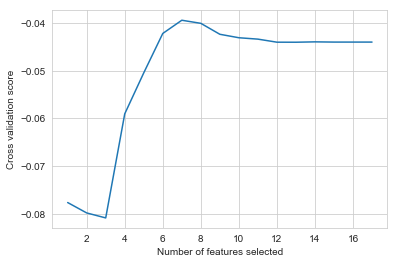

In [107]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

### Applyig LR model on test data. Test accuracy score is 0.85

In [108]:
y_pred = selector.predict(X_test)

Compariso of actuals vs predicted for test data

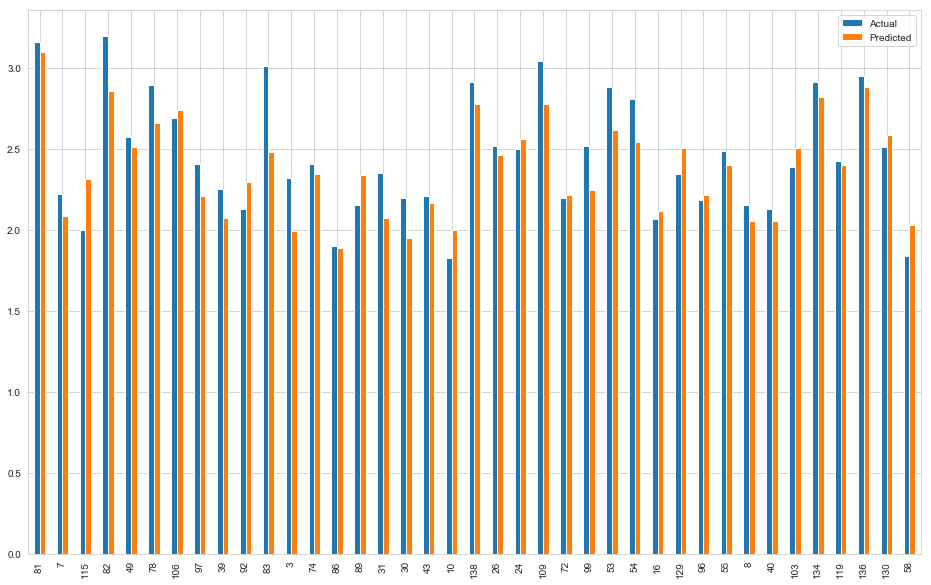

In [109]:
df_compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_compare.plot(kind='bar',figsize=(16,10))
plt.show()

Scores for test data set.

In [110]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score:', metrics.r2_score(y_test, y_pred))
print('Accuracy score:', np.sqrt(metrics.r2_score(y_test, y_pred)))

Mean Absolute Error: 0.15373816019260234
Mean Squared Error: 0.03650771916825173
Root Mean Squared Error: 0.19106993266406866
R2 score: 0.7256596996827887
Accuracy score: 0.8518566192046574


Scatter plot for actual vs predicted for test data

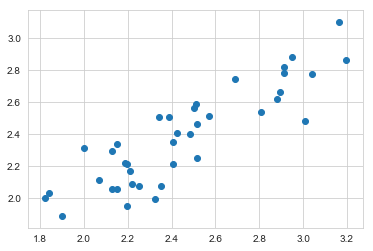

In [111]:
p=plt.scatter(y_test,y_pred)

Below we tried doing RFE without cross validation. This is not used for doing predictions but just to show the feature ranks we are getting with this.

In [112]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,y)
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), cols)))


Features sorted by their rank:
[(1, 'time_3'), (2, 'cos_time'), (3, 'time_2'), (4, 'sin_time'), (5, 'electricity_flooding'), (6, 'Occurrence_involving_freight'), (7, 'day'), (8, 'Intermittent_Semaphore'), (9, 'Incident_involving_dangerous_freight'), (10, 'Running_over'), (11, 'Trolleybuses_tree'), (12, 'Semaphore_off'), (13, 'broken_vehicle'), (14, 'Fire'), (15, 'Accident_victim'), (16, 'Fire_Manifestations'), (17, 'Vehicle_excess')]


### Applying LR model on training data. Training data accuracy score is 0.87

In [113]:
y_pred_train = selector.predict(X_train)

Comparison of actual vs predicted for training data set

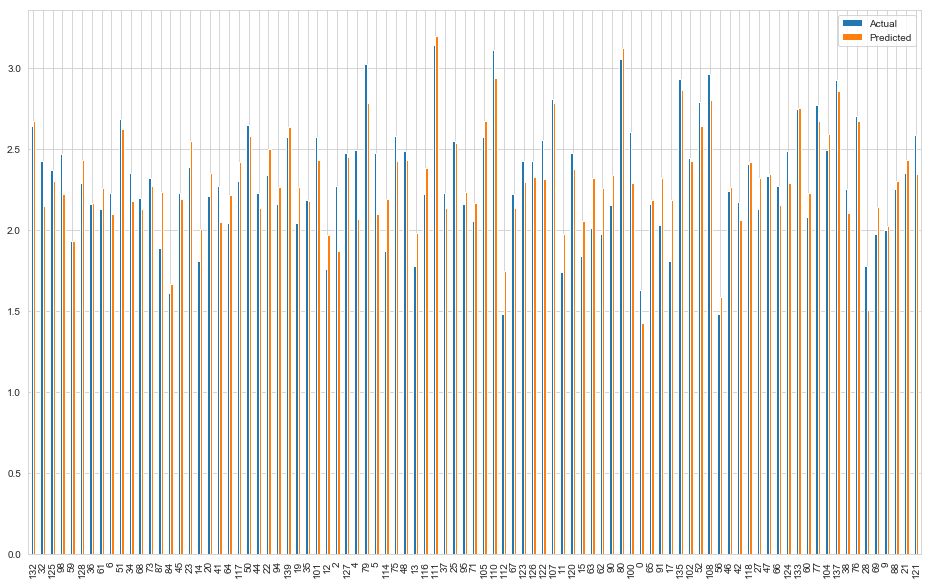

In [114]:
df_compare = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_train})
df_compare.plot(kind='bar',figsize=(16,10))
plt.show()

Scores for training data set using LR model.

In [115]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('R2 score:', metrics.r2_score(y_train, y_pred_train))
print('Accuracy score:', np.sqrt(metrics.r2_score(y_train, y_pred_train)))

Mean Absolute Error: 0.14224265104862957
Mean Squared Error: 0.030614559992961508
Root Mean Squared Error: 0.17497016886589983
R2 score: 0.7615738440191878
Accuracy score: 0.8726819833245029


Scatter plot of actual vs predicted for training data set.

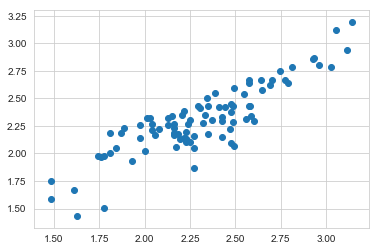

In [116]:
p=plt.scatter(y_train,y_pred_train)

## Model#2: Randomforest model (converting problem to classification)

This is the second of the two models we have built to solve this problem. We decided to convert this problem into classification one because of following reasons:
1. Number of records are less.
2. It would be easier to predict slowness class instead of accurately predicting the exact slowness percentage.

Initially we saw that RandomForest classifier was performing better then Linear regression. However after extensive feature transformation was done to  fine tune data for Linear regression, LR started performing better. Hence we focused most of our energy on fine tuning Linear regression and implemented RFE wit cross validation for Linear regression only.


We have done important feature analysis for Random Forest towards end.

We have taken backup of data before doing feature transformation. Copying it back to df.

In [117]:
df = df_backup

In [118]:
df_backup.head()

,Vehicle_excess,Accident_victim,Running_over,Occurrence_involving_freight,Incident_involving_dangerous_freight,Fire,Semaphore_off,Intermittent_Semaphore,Slowness_in_traffic_percent,time,day,broken_vehicle,electricity_flooding,Fire_Manifestations,Trolleybuses_tree,time_square,time_log,time_Square_sqroot
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1,420,0,0.0,0.0,0.0,0.0,-1.469511,1101.764702,-1.612052
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.7,480,0,0.0,0.0,0.0,0.0,-1.326234,1286.995794,-1.416299
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2,510,0,0.0,0.0,0.0,0.0,-1.247431,1380.860790,-1.313630
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.1,540,0,0.0,0.0,0.0,0.0,-1.163853,1475.492630,-1.207896
5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.9,570,0,0.0,0.0,0.0,0.0,-1.075498,1570.848668,-1.099182


Not much of transformation on data is needed since we are using decision tree based Random forest. Below features were not getting handled correctly, hence converted them

In [119]:
df = df.drop(['time_square','time_Square_sqroot','time_log'],axis=1)

Binning of target is done in custom way to create 4 classes of traffic congestion:

    Class # 1: <=7%  --> No or minimal traffic
    Class # 2: <=12% --> Medium traffic
    Class # 3: <=20% --> High traffic
    Class # 4: > 20  --> Very high traffic

In [120]:
# Features
X = df.drop(['Slowness_in_traffic_percent'],axis=1)

# Target
aba=[]
for i in df['Slowness_in_traffic_percent']:
    if i <= 7:
        aba.append(0)
    elif i <= 12:
        aba.append(1)
    elif i<=20:
        aba.append(2)
    else:
        aba.append(3)

df['slowness_class']=aba
y = df['slowness_class']


Split data into test and train.

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=75)


Using RandomForest classifier model is built and predictions are done on test data

In [122]:
model = RandomForestClassifier(n_estimators=100, random_state=0, oob_score=True, n_jobs=-1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

Evaluation of model. RFE and cross validation is not done on this model as we found that Linear regression was giving better results.

In [123]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8717948717948718


In [124]:
warnings.filterwarnings('ignore')
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.91      0.91      0.91        22
           2       0.82      0.90      0.86        10
           3       1.00      0.50      0.67         2

   micro avg       0.87      0.87      0.87        39
   macro avg       0.88      0.78      0.81        39
weighted avg       0.88      0.87      0.87        39



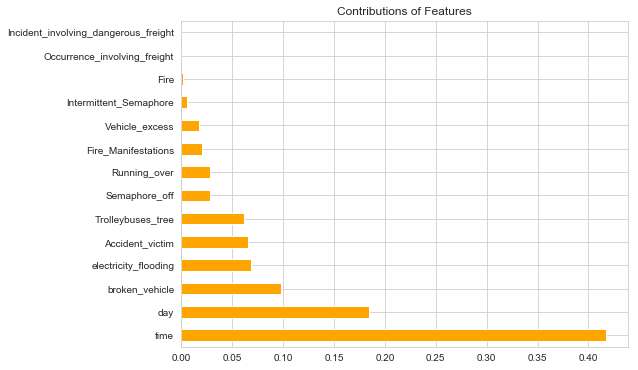

In [125]:
#Contributions of features in the above model
ax = (pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(19)
   .plot(kind='barh', figsize=(8,6), color='orange'))
plt.title('Contributions of Features')
plt.show()

# Model#3: RandomForest Regressor
We have tried out a third model treating this problem as a regression problem. We wanted to compare accuracy between linear regression and random forest regressor. Below we have captured results. Due to lack of time we could not do further analysis on what are the important factors identified by this model.

In [126]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
df = df_backup
X = df.drop(['Slowness_in_traffic_percent'],axis=1)
y = df['Slowness_in_traffic_percent']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=75)
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],
                            random_state=False, verbose=False)
scores = cross_val_score(rfr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
scores

array([-1.11289377, -0.88303522, -1.30521849, -2.33039061, -1.76274234,
       -1.27414114, -1.22634779, -1.56231217, -1.73270651, -1.08233489])

In [127]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(rfr, X_test, y_test, cv=10)

In [128]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score:', metrics.r2_score(y_test, y_pred))
print('Accuracy score:', np.sqrt(metrics.r2_score(y_test, y_pred)))


Mean Absolute Error: 1.928770120904735
Mean Squared Error: 6.394605978747085
Root Mean Squared Error: 2.528755816354573
R2 score: 0.7243268394797542
Accuracy score: 0.8510739330280033


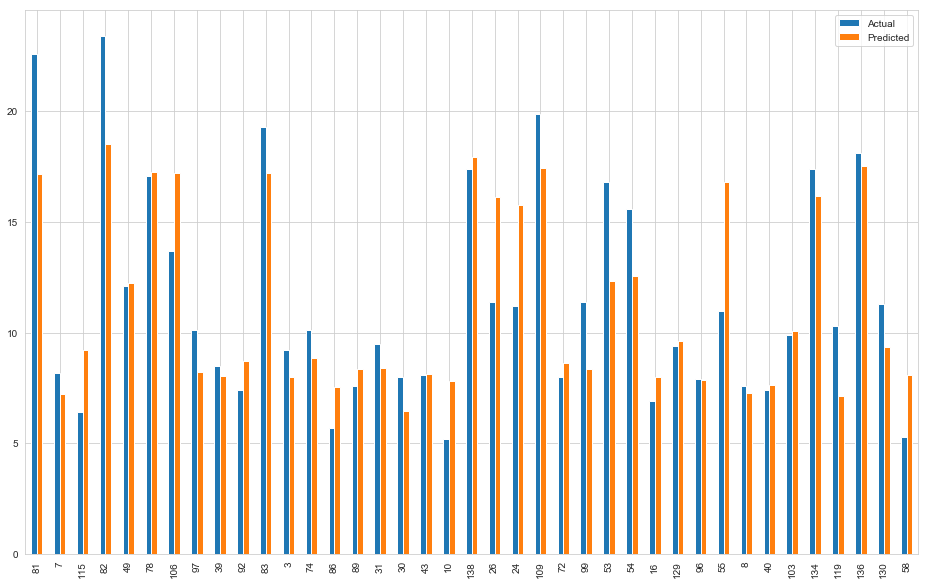

In [129]:
df_compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_compare.plot(kind='bar',figsize=(16,10))
plt.show()

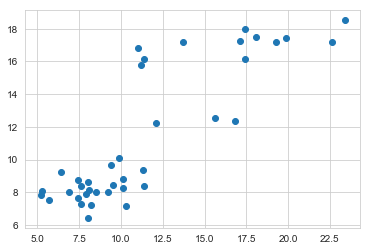

In [130]:
p=plt.scatter(y_test,y_pred)